In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn import metrics
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils import shuffle
from keras.models import Sequential
from keras import Input
from keras.layers import SimpleRNN, LSTM
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
%matplotlib inline
# tf crash fix
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
df = pd.read_csv("../ready_data/winter_2022.csv")
test_df = pd.read_csv("../ready_data/test_day.csv")

In [3]:
num_cols = ['airTemp', 'humidity', 'dewpoint', 'Friction',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm']

In [4]:
df["sequence"] = df.index + 1
df = df.drop("ts", axis = 1)

test_df["sequence"] = test_df.index + 1
test_df = test_df.drop("ts", axis = 1)


In [5]:
# To get the number of variables
n_features = len(num_cols)

In [6]:
timestep_size = 36

input_windows = sliding_window_view(df[num_cols].values, window_shape=(timestep_size, n_features))[::timestep_size]

target_windows = sliding_window_view(df['Friction'].values, window_shape=(timestep_size))[::timestep_size]
targets = target_windows[:,-1]

inputs = input_windows.reshape(-1,timestep_size, n_features)

X= inputs
y = targets

X,y = shuffle(X,y, random_state=42)

In [7]:
 # define the cutoff point
train_size = 0.8
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [8]:
model = Sequential()

model.add(LSTM(64, activation="relu", input_shape=x_train.shape[1:], return_sequences=True))
model.add(LSTM(32, activation="relu", return_sequences=True))
model.add(LSTM(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "LTSM.keras", save_best_only=True, monitor="loss", mode="min"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50, verbose=1),
]

model.fit(x_train, y_train, epochs=500, verbose=1, callbacks=callbacks)




Epoch 1/500

16/16 [==============================] - 3s 17ms/step - loss: 4719.9536 - lr: 0.0010
Epoch 2/500
16/16 [==============================] - 0s 16ms/step - loss: 1165.7975 - lr: 0.0010
Epoch 3/500
16/16 [==============================] - 0s 14ms/step - loss: 3505.9194 - lr: 0.0010
Epoch 4/500
16/16 [==============================] - 0s 16ms/step - loss: 739.8121 - lr: 0.0010
Epoch 5/500
16/16 [==============================] - 0s 14ms/step - loss: 1893.3992 - lr: 0.0010
Epoch 6/500
16/16 [==============================] - 0s 16ms/step - loss: 961.9788 - lr: 0.0010
Epoch 7/500
16/16 [==============================] - 0s 16ms/step - loss: 158.6029 - lr: 0.0010
Epoch 8/500
16/16 [==============================] - 0s 16ms/step - loss: 130.4691 - lr: 0.0010
Epoch 9/500
16/16 [==============================] - 0s 14ms/step - loss: 325.4171 - lr: 0.0010
Epoch 10/500
16/16 [==============================] - 0s 15ms/step - loss: 570.9565 - lr: 0.0010
Epoch 11/500
16/16 [============

<Axes: >

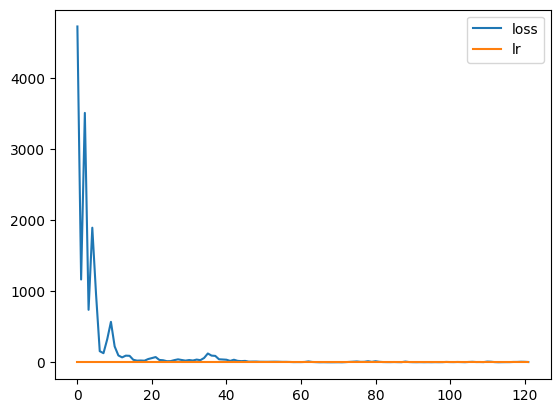

In [9]:
 # the usual training metric visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [10]:
model = keras.models.load_model("LTSM.keras")

In [11]:
forecast_steps = 12

test = test_df[:-forecast_steps]
sequence = test[-37:]

input_windows = sliding_window_view(sequence[num_cols].values, window_shape=(timestep_size, n_features))[::timestep_size]
last_input = input_windows.reshape(-1,timestep_size, n_features)

In [12]:
future_predictions = []
for _ in range(forecast_steps):
    next_pred = model.predict(last_input)  # Predict the next time step
    # Extract the predicted class with the highest probability (using argmax)
    future_predictions.append(next_pred)  # Append the prediction to the list
    # Update the sequence by adding the predicted value and removing the oldest value
    last_input = np.roll(last_input, shift=-1, axis=1)
    last_input[0, -1, 0] = next_pred[0]


1/1 [==============================] - ETA: 0s

C:\Users\kiril\AppData\Local\Temp\ipykernel_22780\2535987490.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1, 0] = next_pred[0]


1/1 [==============================] - 0s 19ms/step


In [13]:
print(future_predictions)

[array([[0.8646601]], dtype=float32), array([[1.3593323]], dtype=float32), array([[0.8067312]], dtype=float32), array([[1.3810016]], dtype=float32), array([[1.3681898]], dtype=float32), array([[1.8447891]], dtype=float32), array([[0.72975653]], dtype=float32), array([[0.54556036]], dtype=float32), array([[1.5598397]], dtype=float32), array([[0.850879]], dtype=float32), array([[-0.00952581]], dtype=float32), array([[-0.38015777]], dtype=float32)]


In [14]:
res = []
for pred in future_predictions:
    res.append(pred[0])
res = pd.DataFrame(res)

res = res.rename({"0":"Friction"}, axis=1)

In [15]:
result = pd.concat([test.Friction, res], ignore_index=True)
result

,0
0,0.454719
1,0.452732
2,0.449021
3,0.446597
4,0.446995
...,...
139,0.545560
140,1.559840
141,0.850879
142,-0.009526


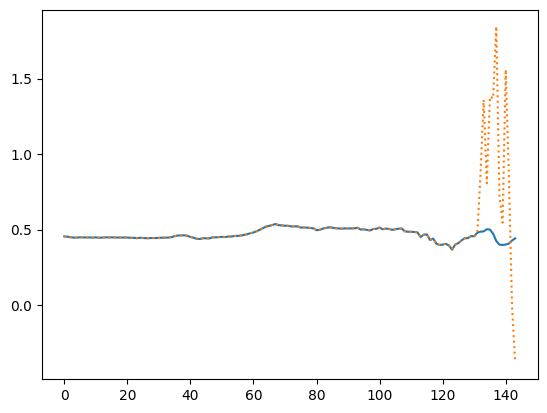

In [16]:
plt.plot(test_df.index, test_df.Friction)
plt.plot(result.index, result[0], linestyle = ":")
plt.show()